# Predictive model and feature importance for state level homelessness

*CS109A/AC209A Group 8 final project*

**Contact info:** Renhao Luo (renhao_luo@hms.harvard.edu), Ziqi Wang (ziqiwang@hms.harvard.edu), Shun Li (shunli@g.harvard.edu), Linzi Yu (linzi_yu@hms.harvard.edu), Senmiao Sun (sun_senmiao@g.harvard.edu)

<hr style="height:2pt">

In [1]:
# Install dependencies
!pip install plotly
!pip install missingno
!pip install shap

  Using cached shap-0.41.0.tar.gz (380 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for shap (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [125 lines of output]
      <string>:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
      <string>:25: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
      The nvcc binary could not be located in your $PATH. Either  add it to your path, or set $CUDAHOME to enable CUDA
      Error building cuda module: TypeError('cannot unpack non-iterable NoneType object')
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.1-arm64-cpython-39
      creating build/lib.macosx-11.

In [13]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import missingno as mn
# import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
import xgboost as xgb
from xgboost import XGBRegressor

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DataConversionWarning)

<a id='toc1_'></a>

## Introduction

By recent estimates, over 600,000 Americans live in some state of homelessness each year. In recent decades, the quality of available data on homelessness in the United States has greatly improved, but there is still a long way to go. 

In this project, we combined different state-level statistics (housing, income, and political involvement) that are related to homelessness, and build multiple regression models for predicting the number homeless people in the United States. In addition, we discussed about the most important predictors for the machine learning models. In a word, we aim to enhance our understanding of the causes of homelessness from different perspectives by interpreting the most important features highlighted by the machine learning models.

The state level homeless data we used were from Kaggle (https://www.kaggle.com/code/adamschroeder/homelessness-comparison-between-states/data), which contains the data collected by the US Department of Housing and Urban Development (HUD). 

For model prediction, we also included features from these datasets:
- Zillow Housing Data: https://www.kaggle.com/datasets/zillow/zecon
- US Economics Profile by county: https://www.kaggle.com/datasets/davidbroberts/us-economic-profile-by-county?resource=download&select=profile_by_county_1969_2019.csv
- County Presidential Election Returns 2000-2020: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ






**Table of contents**<a id='contents'></a>    
- [**Introduction**](#toc1_)
- [**Data Preprocessing and Exploratory Data Analysis (EDA)**](#toc2_)    
  - [Homeless data preprocess](#toc2_1_)    
  - [Housing data preprocess](#toc2_2_)
  - [Politics data preprocess](#toc2_3_)    
  - [Economic profile data preprocess](#toc2_4_)    
  - [Merge datasets](#toc2_5_)    
  - [Missing values](#toc2_6_)    
  - [Correlation between each variable and homeless count](#toc2_7_)
  - [Combined data preprocess: categorical variable, impute missing data, feature scaling](#toc2_8_)
- [**Regression Modeling and Evaluation**](#toc3_)    
  - [Baseline model](#toc3_1_)   
  - [Multivariate linear model](#toc3_2_)   
  - [AdaBoostRegression Model](#toc3_3_)   
  - [RandomForest Regression model](#toc3_4_)   
  - [Bagging Regression model](#toc3_5_)   
  - [XGBRegressor model](#toc3_6_)   
  
<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<a id='toc2_'></a>
# Data Preprocessing and Exploratory Data Analysis (EDA)

[Return to contents](#contents)

Here, we preprocess the homeless data, housing data, economics data and political involvement data of each state, and then combine the predictors and response variable in each state for year 2008 and 2016 (presidential election years).

<a id='toc2_1_'></a>
## Homeless data preprocess

[Return to contents](#contents)

In [ ]:
df_homeless = pd.read_csv("../data/2007-2016-Homelessnewss-USA.csv")
df_homeless.head()

In [ ]:
# extract the year and add a new column to the dataframe
df_homeless['Year_only'] = pd.DatetimeIndex(df_homeless['Year']).year 

# subset the homeless data to only contain data from year 2008 and 2016
df_homeless_sub = df_homeless[df_homeless['Year_only'].isin([2008, 2016])]
df_homeless_sub.head()

In [ ]:
# describe the dataframe
df_homeless_sub.describe()

Note: The homeless data acquired from the U.S. Department of Housing and Urban Development uses the Continuums of Care (CoC) number, which divides each state into different geographic area. However, it does not necessarily match with the known zip code or county boundaries, which makes it hard to join this data with other county level data. Therefore, we first explore the data at states level. 

In [ ]:
# Convert the count to numeric
# homeless_df_sub["Count"] = pd.to_numeric(homeless_df_sub["Count"])
# homeless_df_sub.info()

In [ ]:
# aggregate the data into state level
df_homeless_sub = df_homeless_sub.groupby(["Year_only","State"])["Count"].sum().reset_index()
df_homeless_sub.columns = ["year", "state_abbrev", "homeless_count"]
df_homeless_sub

Visualize the homelessness dataset by state:

In [ ]:
# set font
font = {'size'   : 16}
plt.rc('font', **font)

# plot the number of homeless people per state
plt.figure(figsize=(18,6))
sns.barplot(y='homeless_count', x='state_abbrev', hue="year", data=df_homeless_sub)
plt.ylabel('homeless people count')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Homeless people count across states in 2008 and 2016')
plt.grid();

Choropleth graph of homeless count by state

In [ ]:
fig = px.choropleth(df_homeless_sub.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='homeless_count',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Homeless Count by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

fig = px.choropleth(df_homeless_sub.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='homeless_count',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Homeless Count by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

<a id='toc2_2_'></a>
## Housing data preprocess

[Return to contents](#contents)

Perform EDA analysis on the housing-related predictors. 

In [ ]:
# Load the housing price dataset
df_housing = pd.read_csv("../data/State_time_series.csv")
df_housing.head()

In [ ]:
# dictionary help to convert the state name to abbrevation

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "WestVirginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "DistrictofColumbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}

In [ ]:
# extract the year of the sold date and add a new column to the dataframe
df_housing['year'] = pd.DatetimeIndex(df_housing['Date']).year 

# subset the housing price data to 2008 and 2016
df_housing_sub = df_housing[df_housing['year'].isin([2008, 2016])]

# convert state full name to abbreviation
df_housing_sub["state_abbrev"] = df_housing_sub["RegionName"].map(us_state_to_abbrev)

df_housing_sub = df_housing_sub.groupby(["year","state_abbrev"])[["Sale_Prices", "MedianListingPricePerSqft_1Bedroom", "MedianListingPricePerSqft_2Bedroom", "MedianListingPricePerSqft_3Bedroom", "MedianListingPricePerSqft_4Bedroom", "MedianListingPricePerSqft_5BedroomOrMore"]].mean().reset_index()#.to_csv("Housing_data.csv", index=False)


In [ ]:
# plot the housing price per state
plt.figure(figsize=(18,6))
sns.barplot(y='Sale_Prices', x='state_abbrev', hue="year", data=df_housing_sub)
plt.ylabel('housing sale price in USD')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Housing sale price across states in 2008 and 2016')
plt.grid();

<a id='toc2_3_'></a>
## Political data preprocess

[Return to contents](#contents)

Perform EDA analysis on the political-related predictors. 

In [ ]:
# Load the politics dataset
df_politics = pd.read_csv("../data/countypres_2000-2020.csv")
df_politics.head()

In [ ]:
# subset the data to 2008 and 2016
df_politics_sub = (
df_politics.query("year == 2008 or year == 2016")
            .query("party == 'DEMOCRAT'")
            .rename(columns = {"state_po":"state_abbrev"})
            .groupby(["year", "state_abbrev"]).sum().reset_index()
)[['year', 'state_abbrev', 'candidatevotes', 'totalvotes']]


# calculate the percentage vote to democrat as a candidate predictor
df_politics_sub['democrat_perc'] = df_politics_sub['candidatevotes']/df_politics_sub['totalvotes'] * 100

df_politics_sub = df_politics_sub[['year', 'state_abbrev', 'democrat_perc']]
df_politics_sub.head()

In [ ]:
df_politics_sub

In [ ]:
# plot the politics indicator per state
plt.figure(figsize=(18,6))
sns.barplot(y='democrat_perc', x='state_abbrev', hue="year", data=df_politics_sub)
plt.ylabel('democrat percentage (%)')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Democrat vote percentage across states in 2008 and 2016')
plt.grid();

In [ ]:
# Choropleth graph of political party by state 2008
# color_scale = {'Republican': 'red', 'Democrat': 'blue'}

fig = px.choropleth(df_politics_sub.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='democrat_perc',
                    color_continuous_scale="Spectral", 
                    )

fig.update_layout(
      title_text = 'Political Party by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

# Choropleth graph of political party by state 2016
# color_scale = {'Republican': 'red', 'Democrat': 'blue'}

fig = px.choropleth(df_politics_sub.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='democrat_perc',
                    color_continuous_scale="Spectral", 
                    )

fig.update_layout(
      title_text = 'Political Party by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()


<a id='toc2_4_'></a>
## Economic profile data preprocess

[Return to contents](#contents)

Perform EDA analysis on the economics-related predictors. 

In [ ]:
df_econ = pd.read_csv("../data/profile_by_county_1969_2019.csv", encoding='latin-1')
states_FIPS = ['01000', '02000', '03000', '04000', '05000', '06000', '07000', '08000', '09000']
for i in range(10, 57):
    fips = str(i)+'000'
    states_FIPS.append(fips)

df_econ['GeoFIPS'] = df_econ['GeoFIPS'].str.slice(2,7)

econ_cols = [' Per capita personal income 4/', ' Per capita net earnings 4/', 'Total employment (number of jobs)', ' Average wages and salaries']

In [ ]:
df_econ_sub = (df_econ[['GeoFIPS', 'GeoName', 'Description', '2008', '2016']]
                 .query("GeoFIPS in @states_FIPS")
                 .query("Description in @econ_cols")
                 .assign(state_abbrev = df_econ['GeoName'].map(us_state_to_abbrev))
                 .drop(columns = ['GeoFIPS', 'GeoName'])               
                )

df_econ_sub

In [ ]:
# subset data from 2008 and 2016
df_econ_sub_08 = (df_econ_sub.drop(columns = ['2016'])
                             .assign(year = 2008)
                 )
df_econ_sub_16 = (df_econ_sub.drop(columns = ['2008'])
                             .assign(year = 2016)
                 )

In [ ]:
df_econ_sub_08 = (df_econ_sub_08.pivot_table(index=['year', 'state_abbrev'], columns='Description', values='2008', aggfunc='sum').reset_index()
                  .rename(columns = {' Average wages and salaries':"AvgSalary", ' Per capita net earnings 4/':"PerCapNetEarning", ' Per capita personal income 4/':"PerCapNetIncome", "Total employment (number of jobs)":"TotalNumJobs"})
                 )

df_econ_sub_16 = (df_econ_sub_16.pivot_table(index=['year', 'state_abbrev'], columns='Description', values='2016', aggfunc='sum').reset_index()
                  .rename(columns = {' Average wages and salaries':"AvgSalary", ' Per capita net earnings 4/':"PerCapNetEarning", ' Per capita personal income 4/':"PerCapNetIncome", "Total employment (number of jobs)":"TotalNumJobs"})
                 )


In [ ]:
# combined table of economic data
df_econ_sub = pd.concat([df_econ_sub_08, df_econ_sub_16])
df_econ_sub.head()

In [ ]:
# change column data type for following data preprocessing
df_econ_sub["AvgSalary"] = pd.to_numeric(df_econ_sub["AvgSalary"])
df_econ_sub["PerCapNetEarning"] = pd.to_numeric(df_econ_sub["PerCapNetEarning"])
df_econ_sub["PerCapNetIncome"] = pd.to_numeric(df_econ_sub["PerCapNetIncome"])
df_econ_sub["TotalNumJobs"] = pd.to_numeric(df_econ_sub["TotalNumJobs"])

In [ ]:
# plot the economics indicator per state
plt.figure(figsize=(18,6))
sns.barplot(y='TotalNumJobs', x='state_abbrev', hue="year", data=df_econ_sub)
plt.ylabel('total number of jobs')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Total number of jobs across states in 2008 and 2016')
plt.grid();

In [ ]:
# Choropleth graph of Total Number of Jobs by state
fig = px.choropleth(df_econ_sub.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='TotalNumJobs',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Total Number of Jobs by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

fig = px.choropleth(df_econ_sub.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='TotalNumJobs',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Total Number of Jobs by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

<a id='toc2_5_'></a>
## Merge Datasets

[Return to contents](#contents)

In [ ]:
# # merge datasets into a final dataframe
# df_homeless_housing = pd.merge(df_homeless_sub, df_housing_sub, how="left", left_on=["year", "state_abbrev"], right_on=["Year_only", "state_abbrev"]).drop(columns=['Year_only'])
# # df_homeless_housing.to_csv("../data/homeless_count_with_housing_price_by_state000.csv", index=False)

In [ ]:
# econ_politics = pd.read_csv("../data/homeless_count_Econ_Politics_by_state.csv")
# econ_politics.rename(columns={"state_abbrev": "state"},inplace=True)
# econ_politics

In [ ]:
# combined = pd.concat([econ_politics, df_homeless_housing.drop(columns=['year', 'state_abbrev','homeless_count'])], axis=1, join="inner")
# combined

In [ ]:
# combined1 = pd.concat([econ_politics, df_homeless_housing.drop(columns=['year', 'state_abbrev','homeless_count'])], axis=1, join="inner")
# combined1

In [ ]:
df_combined = (df_homeless_sub.merge(df_politics_sub, how = "left", on = ['year', 'state_abbrev'])
                                  .merge(df_econ_sub, how = "left", on = ['year', 'state_abbrev'])
                                  .merge(df_housing_sub, how = "left", on = ['year', 'state_abbrev'])
                  )
df_combined.rename(columns={"state_abbrev": "state"},inplace=True)

df_combined.head()

In [ ]:
df_combined.info()

<a id='toc2_6_'></a>
## Missing Values

[Return to contents](#contents)

Check the data missingness across columns, plot the missingness.

In [ ]:
print(df_combined.isna().sum())

mn.matrix(df_combined,figsize=(8,4))

We have more data missing on the housing prices dataset, and less missingness on the politics data.

States such as Guam, American Samoa, Northern Mariana Islands, Puerto Rico, US Minor Outlying Islands, Virgin Islands have missing values. We hypothesized that the data were missing at random. 

<a id='toc2_7_'></a>

## Correlation between each variable and homeless count

[Return to contents](#contents)

In [ ]:
df_combined.columns

In [ ]:
plt.figure(figsize=(16, 8))
g_16 = sns.pairplot(df_combined.query("year == 2016"), 
             x_vars=["democrat_perc","AvgSalary","PerCapNetEarning", "PerCapNetIncome", "TotalNumJobs", 'Sale_Prices'],
             y_vars=["homeless_count"])

g_16.fig.suptitle('Correlation between each variable and homeless count in 2016', fontsize = 16)
g_16.fig.tight_layout()

In [ ]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(pd.merge(df_homeless_sub, df_housing_sub, how="left", left_on=["year", "state_abbrev"], right_on=["year", "state_abbrev"]).drop(columns = ['year']).corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
heatmap.set_title('Correlation Heatmap for Housing predictors', fontdict={'fontsize':18}, pad=12);

In [ ]:
plt.figure(figsize=(10, 6))
heatmap_08 = sns.heatmap(df_combined[["homeless_count", "democrat_perc","AvgSalary","PerCapNetEarning", "PerCapNetIncome", "TotalNumJobs"]].corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
heatmap_08.set_title('Correlation Heatmap for Economics and Politics Predictors', fontdict={'fontsize':18}, pad=12)

<a id='toc2_8_'></a>

# Combined data preprocess

[Return to contents](#contents)

In [ ]:
# ecopolitics = pd.read_csv("../data/homeless_count_Econ_Politics_by_state.csv")
# ecopolitics.rename(columns={"state_abbrev": "state"}, inplace=True)
# ecopolitics

In [ ]:
# housingprice = pd.read_csv("../data/homeless_count_with_housing_price_by_state.csv")
# housingprice.rename(columns={"Year_only": "year"}, inplace=True)
# housingprice

In [ ]:
# combined = pd.concat([ecopolitics, housingprice.drop(columns=['year', 'state_abbrev','homeless_count'])], axis=1, join="inner")
# combined

### Categorical variable preprocessing

In [ ]:
# Categorical variables: state_abbrev (use one-hot encoding later)
enc = OrdinalEncoder()
# enc = OneHotEncoder(handle_unknown='ignore')
df_combined['state'] = enc.fit_transform(df_combined[['state']])

df_combined

### Impute missing data

In [ ]:
# kNN imputer
knn_imp = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(knn_imp.fit_transform(df_combined))
df_imputed.columns = df_combined.columns

# exclude the state
df_imputed = df_imputed.drop(columns = "state")
df_imputed

### Data standardization
Here we standardize our data for training different models by each member. 

In [ ]:
scaler = StandardScaler()
df_imputed_scaled = scaler.fit_transform(df_imputed)
df_imputed_scaled = pd.DataFrame(df_imputed_scaled, columns=df_imputed.columns)
df_imputed_scaled
X_scaled = df_imputed_scaled.drop(columns='homeless_count')
y_scaled = df_imputed_scaled['homeless_count']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=300) # set seed for reproducibility


# X_train.to_csv("../data/scaled_X_train.csv", index=False)
# X_test.to_csv("../data/scaled_X_test.csv", index=False)
# y_train.to_csv("../data/scaled_y_train.csv", index=False)
# y_test.to_csv("../data/scaled_y_test.csv", index=False)

<a id='toc3_'></a>

# Regression Modeling and Evaluation
[Return to contents](#contents)

<a id='toc3_1_'></a>

## Baseline Model

[Return to contents](#contents)

In [ ]:
predictor = 'TotalNumJobs'
baseline_linreg = LinearRegression().fit(X_train[predictor].values.reshape(-1,1), y_train)

In [ ]:
#Predict
y_pred_train = baseline_linreg.predict(X_train[predictor].values.reshape(-1,1))
y_pred_test = baseline_linreg.predict(X_test[predictor].values.reshape(-1,1))

#Compute the MSE of the model
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred_test)
base_model_r2 = r2_score(y_test, y_pred_test)

print("Linear regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTest R-squared\t{base_model_r2:.4f}")

In [ ]:
baseline_model_slope =baseline_linreg.coef_
baseline_model_intercept = baseline_linreg.intercept_

baseline_model_params = [baseline_linreg.intercept_, *baseline_linreg.coef_]
baseline_model_params_df = pd.DataFrame(baseline_model_params, columns = ["Coefficient"], index=["intercept"]+[str(i) for i in [predictor]])
baseline_model_params_df

### Plot the baseline model

In [ ]:
# Preliminary plotting
x_lin = np.linspace(min(X_train[predictor].values), max(X_train[predictor].values), 1000).reshape(-1, 1)

# split the x and y coords for plotting
pred_curve_y = [i*baseline_model_slope[0] + baseline_model_intercept for i in x_lin]

sns.scatterplot(data=df_imputed,x=X_train[predictor],y=y_train,alpha=0.8, label="train data")
sns.scatterplot(data=df_imputed,x=X_test[predictor],y=y_test,alpha=0.8, label="test data")
plt.plot(x_lin, pred_curve_y, label = f"prediction curve", c='red')
plt.title(f"Based line model: ($R^2$ = {base_model_r2:.4f})")
plt.legend();

<a id='toc3_2_'></a>
## Multivariate linear model
[Return to contents](#contents)

In [ ]:
%matplotlib inline

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [10]:
# Read in data
X_train = pd.read_csv("../data/scaled_X_train.csv")
y_train = pd.read_csv("../data/scaled_y_train.csv")
X_test = pd.read_csv("../data/scaled_X_test.csv")
y_test = pd.read_csv("../data/scaled_y_test.csv")

# exclude the year column
X_train = X_train.drop(columns = "year")
X_test = X_test.drop(columns = "year")

X_train.head()

,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,1.187014,1.023277,0.984646,0.850506,0.178410,1.221901,-0.004104,-0.036893,0.021631,0.023977,-0.025684
1,1.199637,0.023937,-0.383640,-0.462143,-0.750147,-0.009682,0.026937,0.080594,0.070108,-0.025834,-0.083322
2,-0.572699,-1.057257,-1.294860,-1.396147,-0.280227,-1.590602,-0.473441,-0.440902,-0.402933,-0.376713,-0.337893
3,0.833619,0.072848,0.041553,-0.012319,0.112448,0.760825,-0.216729,-0.353839,-0.324579,-0.287681,-0.215065
4,0.756480,-0.606384,-0.832131,-0.890741,-0.309058,0.428678,-0.623486,-0.444504,-0.301532,-0.277814,-0.221680


## Build Lasso model with CV

To find our baseline lasso model, we impleneted cross-validation to find the `best_alpha` that generates the best cross-validation MSE. We also recorded the mean cross-validation MSE across each fold.

In [ ]:
# Initialize lasso model
a_list = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1] # lists of alpha value
lasso_cv = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_train, y_train.values.ravel())

# lasso_cv = LassoCV(cv=10,max_iter=100000,random_state=26).fit(X_train,y_train.values.ravel())

# Store the mean cross-validation MSEs across each fold
lassoCV_val_mses_mean = lasso_cv.mse_path_
# Save the best 𝛼 based on the mean cross-validation MSE
best_alpha_cv = lasso_cv.alpha_
best_alpha_cv

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].scatter(a_list,np.mean(lassoCV_val_mses_mean,axis=1).tolist())
axs[0].set_xscale('log')
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('lassoCV_val_mses_mean')
axs[0].set_title("Mean validation MSE values")

axs[1].scatter(np.linspace(1,lasso_cv.coef_.shape[0],lasso_cv.coef_.shape[0]),lasso_cv.coef_)
axs[1].set_xticks(np.arange(1,lasso_cv.coef_.shape[0]+1))
axs[1].set_xticklabels(X_train.columns, rotation=45, ha='right')
axs[1].set_ylabel('Coefficient value')
axs[1].set_title("Coefficient value")

In [ ]:
# Make predictions
y_train_predict = lasso_cv.predict(X_train)
y_test_predict = lasso_cv.predict(X_test)
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)

print("The train MSE for the lasso model is " + str(train_mse))
print("The test MSE for the lasso model is " + str(test_mse))

# Modal diagnostics
train_score = lasso_cv.score(X_train,y_train)
test_score = lasso_cv.score(X_test,y_test)

print("The train R2 for the lasso model is " + str(train_score))
print("The test R2 for the lasso model is " + str(test_score))

The train and test MSE is small, but the R-squared values for test and training set differ a lot (test R2 is much lower comparing to training R2). Therefore, it seems like the model overfitted.

## Decrease overfitting

Based on our EDA result, our data is highly correlated (especially the Zillow data set).

In [ ]:
corr_matrix = X_train.corr()
high_corr = {}

high_corr_mat = corr_matrix[corr_matrix[abs(corr_matrix)>= 0.95].notna()]
for i in range(high_corr_mat.shape[0]):
    for j in range(high_corr_mat.shape[1]):
        if not np.isnan(high_corr_mat.iloc[i,j]) and i != j:
            if i >= j:
                new_pair = {(high_corr_mat.columns[i],high_corr_mat.columns[j]): high_corr_mat.iloc[i,j]}
            else: 
                new_pair = {(high_corr_mat.columns[j],high_corr_mat.columns[i]): high_corr_mat.iloc[i,j]}
            high_corr.update(new_pair)

            
print("The following pairs of predictor variables have correlation greater than 0.95 or less than -0.95:")
display(high_corr)

It seems like the input data from Zillow is highly correlated. Therefore, we try to minize the effect of such correlation using either PCA, or directly removing some highly correlated variable.

### PCA of input space

By doing PCA of the original data, we essentialy do not lost information comparing to dropping some variables. Here, we iterate through all possible component number of PCA, and select the best performing one based on mean validation MSE.

Within each iteration, we perform lasso cross-validation to find the best alpha of that iteration.

In [ ]:
# Find the best k
val_mses_mean = []
val_r2_train = []
val_r2_test = []
k_list = [1,2,3,4,5,6,7,8,9,10,11]

for k in k_list:
    X_pca_train = PCA(n_components=k).fit_transform(X_train)
    X_pca_test = PCA(n_components=k).fit_transform(X_test)
    
    # Fit model
    lasso_pca = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_pca_train, y_train.values.ravel())
    # cv_results = cross_validate(linreg, X_pca_train, y_train_scaled, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    best_alpha_idx = find_nearest(a_list,lasso_pca.alpha_)[1]
    # print(find_nearest(a_list,lasso_pca.alpha_))
    val_mses_mean.append(lasso_pca.mse_path_[best_alpha_idx].mean())
    
    # Model diagnostics
    r2_train = lasso_pca.score(X_pca_train,y_train)
    r2_test = lasso_pca.score(X_pca_test,y_test)
    val_r2_train.append(r2_train)
    val_r2_test.append(r2_test)
    print("The train R2 for current lasso_pca model (k = " + str(k) + "): " + str(r2_train))
    print("The test R2 for current lasso_pca model (k = " + str(k) + "): " + str(r2_test))
    
best_k = k_list[val_mses_mean.index(min(val_mses_mean))]
print(f"The best k is {best_k}.")

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(k_list,val_mses_mean,label='Mean validation MSE')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Mean validation MSE')
axs[0].set_title('Mean validation MSE of different k')


axs[1].plot(k_list,val_r2_train,label='Train score')
axs[1].plot(k_list,val_r2_test,label='Test score')
axs[1].axhline(test_score,color='r',label="Test score of baseline lasso model")
axs[1].set_xlabel('k')
axs[1].set_ylabel('R2')
axs[1].set_title('R2 train/test score of different k')
axs[1].legend()

All possible components have similar mean validation MSE except 10. However, even the highest test score achieved after PCA (k=2) is still way lower comparing to the baseline LassoCV model (red line). Therefore, we considered directly dropping those highly correlated variable.

### Drop some variable directly

In [ ]:
display(high_corr)
X_train.head()

In [ ]:
# Drop variable

X_train_drop =  X_train.drop(columns = ["PerCapNetIncome","MedianListingPricePerSqft_1Bedroom",
                            "MedianListingPricePerSqft_5BedroomOrMore"])
X_test_drop =  X_test.drop(columns = ["PerCapNetIncome","MedianListingPricePerSqft_1Bedroom",
                            "MedianListingPricePerSqft_5BedroomOrMore"])
X_train_drop.head()

In [ ]:
# Initialize lasso model
a_list = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1] # lists of alpha value
lasso_drop = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_train_drop, y_train.values.ravel())

# lasso_cv = LassoCV(cv=10,max_iter=100000,random_state=26).fit(X_train,y_train.values.ravel())

# Store the mean cross-validation MSEs across each fold
lassoCV_val_mses_mean = lasso_drop.mse_path_
# Save the best 𝛼 based on the mean cross-validation MSE
best_alpha = lasso_drop.alpha_
best_alpha

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].scatter(a_list,np.mean(lassoCV_val_mses_mean,axis=1).tolist())
axs[0].set_xscale('log')
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('lassoCV_val_mses_mean')
axs[0].set_title("Mean validation MSE values")

axs[1].scatter(np.linspace(1,lasso_drop.coef_.shape[0],lasso_drop.coef_.shape[0]),lasso_drop.coef_)
axs[1].set_xticks(np.arange(1,lasso_drop.coef_.shape[0]+1))
axs[1].set_xticklabels(X_train_drop.columns, rotation=45, ha='right')
axs[1].set_ylabel('Coefficient value')
axs[1].set_title("Coefficient value")

In [ ]:
# Make predictions
y_train_predict = lasso_drop.predict(X_train_drop)
y_test_predict = lasso_drop.predict(X_test_drop)
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)

print("The train MSE for the lasso_drop model is " + str(train_mse))
print("The test MSE for the lasso_drop model is " + str(test_mse))

# Modal diagnostics
train_score = lasso_drop.score(X_train_drop,y_train)
test_score = lasso_drop.score(X_test_drop,y_test)

print("The train R2 for the lasso_drop model is " + str(train_score))
print("The test R2 for the lasso_drop model is " + str(test_score))

After dropping, the test R2 is much lower comparing to the baseline LassoCV model. Therefore, dropping these variable losses some important information about the data, leading to lower test R2 score.

## Build best model and train on the entire training set

Since both PCA and dropping variable do not improve the model performance, we retrain the best lassoCV model we found on the entire training set.

In [ ]:
# Retrain with best alpha and using all the training set
lasso_best = Lasso(alpha=best_alpha_cv,max_iter=100000,random_state=26).fit(X_train,y_train)

# Make predictions
y_train_predict_best = lasso_best.predict(X_train)
y_test_predict_best = lasso_best.predict(X_test)
best_train_mse = mean_squared_error(y_train,y_train_predict_best)
best_test_mse = mean_squared_error(y_test,y_test_predict_best)

print("The train MSE for the lasso model is " + str(best_train_mse))
print("The test MSE for the lasso model is " + str(best_test_mse))

# Modal diagnostics
best_train_score = lasso_best.score(X_train,y_train)
best_test_score = lasso_best.score(X_test,y_test)

print("The train R2 for the lasso model is " + str(best_train_score))
print("The test R2 for the lasso model is " + str(best_test_score))

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(12, 5))

axs.scatter(np.linspace(1,lasso_best.coef_.shape[0],lasso_best.coef_.shape[0]),lasso_best.coef_)
axs.set_xticks(np.arange(1,lasso_best.coef_.shape[0]+1))
axs.set_xticklabels(X_train.columns, rotation=45, ha='right')
axs.set_ylabel('Coefficient value')
axs.set_title("Coefficient value")

As shown in plot above, while all variable have a non-zero coefficients, `TotalNumJobs`, `MedianListingPricePerSqft_1Bedroom`, `MedianListingPricePerSqft_2Bedroom`, `MedianListingPricePerSqft_4Bedroom`,`MedianListingPricePerSqft_3Bedroom`, have the largest absolute coefficient, suggesting they might be important for predicting homeless count.

However, since the `best_alpha` is small, none of the coefficients converges to zero. Moreover, while a test R2 score of LassoCV is higher comparing to our baseline model's test R2 score (~0.29), it is still insufficient to be considered as a good model. Therefore, we explore other options of more complex model, especially decision tree-based models like Bagging, AdaBoost, RandomForest, and XGBoost.

<a id='toc3_2_'></a>
## AdaBoostRegression Model 
[Return to contents](#contents)

AdaBoost stands for Adaptive Boosting, it is a ensemble algorithm that create a combination model by improving the weights of the weak learners. AdaBoost can be used as a regression model for homeless prediction. 

First, we start by training a baseline AdaBoost Regressor without hyperparameter tuning:

In [ ]:
# initialize adaboost regressor
ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), learning_rate=1.0, loss='linear',
         n_estimators=1000, random_state=300) 

# fit the model with training data
ada_model.fit(X_train, y_train)

# train and test prediction 
y_train_pred = ada_model.predict(X_train)
y_test_pred = ada_model.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

ada_train_r2 = ada_model.score(X_train, y_train)
ada_test_r2 = ada_model.score(X_test, y_test)

print("AdaBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{ada_train_r2:.4f}")
print(f"\tTest R-squared\t{ada_test_r2:.4f}")

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred, label="Predicted")
plt.title("Prediction from Untuned AdaBoost Regressor on Testing set")
plt.legend()
plt.show()

The performance is already much better than the baseline model. Now, tune the hyper paramaters:

In [ ]:
# space for hyperparameter tuning
space = {
        'random_state': 300,
        "base_estimator": hp.choice("base_estimator", [DecisionTreeRegressor(max_depth=2), DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4)]),
        'n_estimators':hp.choice('n_estimators', np.arange(1, 200, 1, dtype=int)),
        "learning_rate": hp.choice('learning_rate', [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]),
        'loss': hp.choice('loss', ['linear', 'square', 'exponential'])
        }

hypopt_scores = []

def score(params):
    model = AdaBoostRegressor(**params)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    hypopt_scores.append(score**2)
    
    return {'loss': score, 'status': STATUS_OK}    

def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=1000)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
space_eval(space, best_params)


fit the best model with the selected hyperparameters

In [ ]:
best_params = {'base_estimator': DecisionTreeRegressor(max_depth=3),
                'learning_rate': 0.0001,
                'loss': 'exponential',
                'n_estimators': 50,
                'random_state': 300}

best_adamodel = AdaBoostRegressor(**best_params)
best_adamodel.fit(X_train, y_train)

In [ ]:
# prediction
y_train_pred_best = best_adamodel.predict(X_train)
y_test_pred_best = best_adamodel.predict(X_test)

# calculate MSE and R_squared of the model
train_mse_best = mean_squared_error(y_train, y_train_pred_best)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)

train_r2_best = best_adamodel.score(X_train, y_train)
test_r2_best = best_adamodel.score(X_test, y_test)

print("Hyperparameter Tuned AdaBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_best,
        test_mse_best,
    )
)

print(f"\tTrain R-squared\t{train_r2_best:.4f}")
print(f"\tTest R-squared\t{test_r2_best:.4f}")

### Feature Importance

The plot below shows feautre importance in terms of the number of times a feature appears in a tree. 

In [ ]:
feature_importances_plot = list(zip(list(X_train.columns), best_adamodel.feature_importances_))
feature_importances_plot = sorted(feature_importances_plot, key=lambda x:x[1], reverse=True)
feature_importances_plot_df = pd.DataFrame(feature_importances_plot, columns=['features', "Feature importance"])

ax = feature_importances_plot_df.plot.barh(x="features", y="Feature importance")
for container in ax.containers:
    ax.bar_label(container)
plt.title("AdaBoost Regressor feature importance")

<a id='toc3_2_'></a>
## RandomForest Regression model 
[Return to contents](#contents)

In [ ]:
# train a randomForestRegressor model
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# prediction
y_train_predict = rfr.predict(X_train)
y_test_predict = rfr.predict(X_test)


#Compute the MSE of the model
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)
randomForestRegressor_train_r2 = rfr.score(X_train, y_train)
randomForestRegressor_test_r2 = rfr.score(X_test, y_test)

print("Random Forest Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{randomForestRegressor_train_r2:.4f}")
print(f"\tTest R-squared\t{randomForestRegressor_test_r2:.4f}")

The train and test MSE is small, but the R-squared values differ a lot. Therefore, it seems like the model overfitted. Perform a GridSearchCV

In [ ]:
gsc_rfr = GridSearchCV(
        estimator=RandomForestRegressor(random_state=300),
        param_grid={
            "max_depth": range(1,7),
            'n_estimators': (1,10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result_rfr = gsc_rfr.fit(X_train, y_train.values.ravel())
best_params_rfr = grid_result_rfr.best_params_

grid_rfr = RandomForestRegressor(max_depth = best_params_rfr["max_depth"], n_estimators=best_params_rfr["n_estimators"], bootstrap=True, random_state=300, verbose=False)

grid_rfr.fit(X_train, y_train)

# prediction
y_train_GridCV_predict = grid_rfr.predict(X_train)
y_test_GridCV_predict = grid_rfr.predict(X_test)


#Compute the MSE of the model
train_GridCV_mse = mean_squared_error(y_train,y_train_GridCV_predict)
test_GridCV_mse = mean_squared_error(y_test,y_test_GridCV_predict)
randomForestRegressor_train_GridCV_r2 = grid_rfr.score(X_train, y_train)
randomForestRegressor_test_GridCV_r2 = grid_rfr.score(X_test, y_test)

print("Random Forest Regressor Gridsearch results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_GridCV_mse,
        test_GridCV_mse,
    )
)

print(f"\tTrain R-squared\t{randomForestRegressor_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{randomForestRegressor_test_GridCV_r2:.4f}")

<a id='toc3_2_'></a>
## Bagging Regression model   
[Return to contents](#contents)

In [11]:
bagging_ensemble = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), n_estimators=1, 
                                    max_features=1.0, bootstrap_features=False, random_state=300).fit(X_train, y_train)


# prediction
y_train_bagging_predict = bagging_ensemble.predict(X_train)
y_test_bagging_predict = bagging_ensemble.predict(X_test)


#Compute the MSE of the model
bagging_train_mse = mean_squared_error(y_train,y_train_bagging_predict)
bagging_test_mse = mean_squared_error(y_test,y_test_bagging_predict)
bagging_ensemble_train_GridCV_r2 = bagging_ensemble.score(X_train, y_train)
bagging_ensemble_test_GridCV_r2 = bagging_ensemble.score(X_test, y_test)

print("Bagging Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        bagging_train_mse,
        bagging_test_mse,
    )
)

print(f"\tTrain R-squared\t{bagging_ensemble_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{bagging_ensemble_test_GridCV_r2:.4f}")

Bagging Regressor results:

	Train MSE	0.0219
	Test MSE	0.1940

	Train R-squared	0.9796
	Test R-squared	0.7215


Perform a GridSearchCV to better turn the model

In [12]:
gsc_br = GridSearchCV(
        estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=300), random_state=300),
        param_grid={
            "base_estimator__max_depth": range(1,20),
            'n_estimators': (1,10, 50, 100, 1000)
        },
        cv=10, scoring='neg_mean_squared_error', n_jobs=-1)


grid_result_br = gsc_br.fit(X_train, y_train.values.ravel())
best_params_br = grid_result_br.best_params_

grid_bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=best_params_br["base_estimator__max_depth"], random_state=300),
                                n_estimators=best_params_br["n_estimators"], random_state=300)

grid_bagging.fit(X_train, y_train.values.ravel())

# prediction
y_train_GridCV_predict = grid_bagging.predict(X_train)
y_test_GridCV_predict = grid_bagging.predict(X_test)


#Compute the MSE of the model
train_GridCV_mse = mean_squared_error(y_train,y_train_GridCV_predict)
test_GridCV_mse = mean_squared_error(y_test,y_test_GridCV_predict)

baggingRegressor_train_GridCV_r2 = grid_bagging.score(X_train, y_train)
baggingRegressor_test_GridCV_r2 = grid_bagging.score(X_test, y_test)

print("Bagging Regressor Gridsearch results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_GridCV_mse,
        test_GridCV_mse,
    )
)

print(f"\tTrain R-squared\t{baggingRegressor_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{baggingRegressor_test_GridCV_r2:.4f}")

Bagging Regressor Gridsearch results:

	Train MSE	0.0181
	Test MSE	0.1311

	Train R-squared	0.9831
	Test R-squared	0.8119


### Feature Importance

In [3]:
explainer_baggingRegressor = shap.TreeExplainer(grid_rfr)
shap_values = explainer_baggingRegressor.shap_values(X_train)

shap.summary_plot(shap_values, X_train, title="RandomForestRegressor Feature Importance (Train)")

NameError: name 'shap' is not defined

Since the BaggingRegressor used with many base estimators, and shap library does not support the baggingRegressor, so we need to extract the feature_importances_ ourselves. 

In [4]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in grid_bagging.estimators_
], axis=0)
feature_importances

feature_importances_plot = list(zip(list(X_train.columns), feature_importances))
feature_importances_plot = sorted(feature_importances_plot, key=lambda x:x[1], reverse=True)
feature_importances_plot_df = pd.DataFrame(feature_importances_plot, columns=['features', "Feature importance"])

ax = feature_importances_plot_df.plot.barh(x="features", y="Feature importance")
for container in ax.containers:
    ax.bar_label(container)
plt.title("BaggingRegressor feature importance")

NameError: name 'grid_bagging' is not defined

<a id='toc3_2_'></a>
## XGBRegressor model
[Return to contents](#contents)

In [14]:
# XGBoost Without Hyperparameter Tuning
params = {'random_state': 42,
            'colsample_bytree': 0.5,
             'eta': 0.3,
             'eval_metric': 'rmse',
             'max_depth': 5,
             'min_child_weight': 10,
             'n_estimators': 500,
             'objective': 'reg:squarederror',
             'subsample': 0.8}

xg_model = XGBRegressor(**params)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [15]:
# prediction
y_train_pred = xg_model.predict(X_train)
y_test_pred = xg_model.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = xg_model.score(X_train, y_train)
test_r2 = xg_model.score(X_test, y_test)

print("XGBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{train_r2:.4f}")
print(f"\tTest R-squared\t{test_r2:.4f}")

XGBoost Regressor results:

	Train MSE	0.0001
	Test MSE	0.4171

	Train R-squared	0.9999
	Test R-squared	0.4013


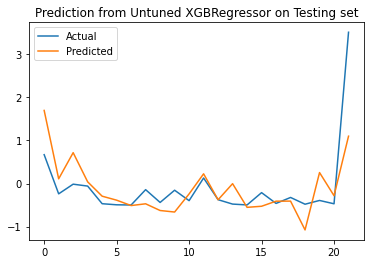

In [16]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred, label="Predicted")
plt.title("Prediction from Untuned XGBRegressor on Testing set")
plt.legend()
plt.show()

### Hyperparameter Tuning with Hypopt

In [ ]:
# !!! This code cell takes about 10mins to run
warnings.filterwarnings('ignore')

# space for hyperparameter tuning
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 20, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(10, 1000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 10, 1, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'eta':hp.quniform('eta', 0.1, 0.3, 0.1),
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
        }

hypopt_scores = []

def score(params):
    model = XGBRegressor(**params)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    hypopt_scores.append(score**2)
    
    return {'loss': score, 'status': STATUS_OK}    

def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=1000)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
space_eval(space, best_params)


### Fit the model with the best hyperparameters

In [17]:
best_params = {'random_state': 42,
               'colsample_bytree': 0.8,
                 'eta': 0.30000000000000004,
                 'eval_metric': 'rmse',
                 'max_depth': 3,
                 'min_child_weight': 4,
                 'n_estimators': 540,
                 'objective': 'reg:squarederror',
                 'subsample': 0.9}

best_xgmodel = XGBRegressor(**best_params)
best_xgmodel.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30000000000000004, eval_metric='rmse', gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=540, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, ...)

In [18]:
# prediction
y_train_pred_best = best_xgmodel.predict(X_train)
y_test_pred_best = best_xgmodel.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse_best = mean_squared_error(y_train, y_train_pred_best)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)

train_r2_best = best_xgmodel.score(X_train, y_train)
test_r2_best = best_xgmodel.score(X_test, y_test)

print("Hyperparameter Tuned XGBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_best,
        test_mse_best,
    )
)

print(f"\tTrain R-squared\t{train_r2_best:.4f}")
print(f"\tTest R-squared\t{test_r2_best:.4f}")

Hyperparameter Tuned XGBoost Regressor results:

	Train MSE	0.0000
	Test MSE	0.1363

	Train R-squared	1.0000
	Test R-squared	0.8043


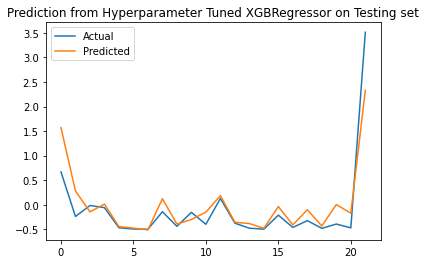

In [19]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred_best, label="Predicted")
plt.title("Prediction from Hyperparameter Tuned XGBRegressor on Testing set")
plt.legend()
plt.show()


### Feature Importance

The plot below shows feautre importance in terms of the number of times a feature appears in a tree. 

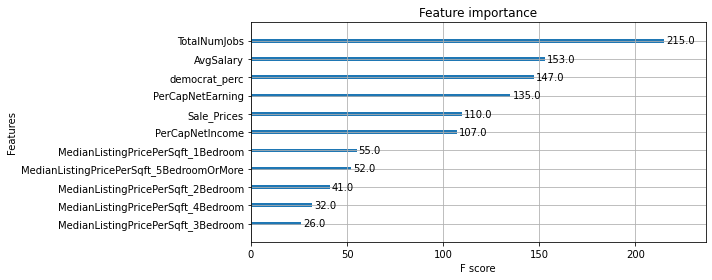

In [20]:
fig, ax = plt.subplots(figsize = (10, 4))
xgb.plot_importance(best_xgmodel, importance_type='weight', ax = ax)
plt.tight_layout()